imoprting necessary libaries


In [14]:
import jax
import jax.numpy as jnp
from jax import jit, vmap
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import os
from jax import random, grad, vmap, jit,jacfwd,jacrev, vjp
from jax.example_libraries import optimizers
from jax.nn import relu, sigmoid, swish, elu, silu , selu
from jax import lax
from jax.flatten_util import ravel_pytree
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib import font_manager
from matplotlib import font_manager
from scipy.interpolate import griddata
import matplotlib.colors as colors
from scipy.interpolate import interp2d
from matplotlib.cm import tab20
import jax.scipy as sp
import os
import time
from jax.numpy.fft import fftn, ifftn, fftshift, ifftshift
from jax.numpy.linalg import inv, det  # Make sure det is imported here
import jaxopt
import optax
from jax.example_libraries.optimizers import optimizer, make_schedule, exponential_decay
from jax.example_libraries.stax import Dense, Gelu, serial
from jax.nn.initializers import glorot_uniform, normal, glorot_normal
import timeit

identify the type of models to used here 

In [15]:
from spifol_archs import MLP, modified_MLP, FNOBlock2D, Permute, Dense, complex_adam

defining the grid for training

In [16]:
n = 64          ## number of pixels per direction
Lx = 1.0                     # length in x
Ly = 1.0                     # length in y
x = np.linspace(0, Lx, n)
y = np.linspace(0, Ly, n)
xx, yy = np.meshgrid(x, y) #this function used for creating the 2D array where in xx has rows are repeated on based on the no. of element of y and in yy columns are repeated on based on the no. of element of x array.
# print(xx)
#converting numpy array to the jax array
xx_jax = jnp.array(xx)   
yy_jax = jnp.array(yy)


materials based on phase-constrant ratio

In [17]:
phase_contrast = 5   ## phase contrast is the ratio of the refractive index of the material to the refractive index of the fluid
lambda_m = 23.19/phase_contrast   ## lambda_m is the Lame's constant for the material
mu_m =  29.51/phase_contrast     ## mu_m is the shear modulus for the material
lambda_f = 23.19 ## Lame's constant for the fluid
mu_f = 29.51               ## posisson's considered to be constant
N =n  ## number of pixels per direction
ndim = 2 ## number of dimensions ## 2D problem x and y dimesions

# material tangents or stiffness tensor or elasticity tensor which is calulated using the hooke's law for isotropic material sigma = C:epsilon(formula of hooke's law)
# initialising the material tangent and fluid tangent as 4th order tensors
# elasticity tensor is the 4th order tensor that why we given the input for 4th times in the zeros function
C_m = np.zeros((ndim,ndim,ndim,ndim)) ## 4th order tensor   ## C_m is the material tangent ## ndim is the number of dimensions ## 4th order tensor is the tensor of rank 4
C_f = np.zeros((ndim,ndim,ndim,ndim)) ## 4th order tensor 


# identity matrix of rank 2
iden = jnp.eye(ndim) ## identity tensor of rank 2 ## ndim is the number of dimensions

C_m = lambda_m * jnp.einsum('ij,kl->ijkl', iden, iden) + \
     mu_m * (jnp.einsum('ik,jl->ijkl', iden, iden) + jnp.einsum('il,jk->ijkl', iden, iden)) ## einsum is used for the tensor contraction 

C_f = lambda_f * jnp.einsum('ij,kl->ijkl', iden, iden) + \
     mu_f * (jnp.einsum('ik,jl->ijkl', iden, iden) + jnp.einsum('il,jk->ijkl', iden, iden))

# Averaging C_m and C_f to get C_0 (refrence material tangent)
C_0 = (C_m + C_f) / 2

# print(C_m)
# print(C_f)
# print(C_m)
# print(C_m.shape)
# print(C_0)
# print(C_0.shape)

define the frequencies

In [18]:
delta = Lx /n ## delta is the grid spacing
h = 2*jnp.pi/Lx ## h is the wave number 
k = jnp.concatenate((jnp.arange(0, n/2 + 1), jnp.arange(-n/2 + 1, 0, 1)))   ## jnp.arange(0, n/2 + 1) is the array from 0 to n/2+1 and jnp.arange(-n/2 + 1, 0, 1) is the array from -n/2+1 to 0 and jnp.concatenate is used to addition(or write in single array) two array the two arrays  ## k is the wave number

#kvec = 1j*h*k ## kvec is the wave number vector
kvec = 1j*jnp.sin(h*delta*k)/ delta ## kvec is the wave number vector
kp, kq = jnp.meshgrid(kvec, kvec, indexing='ij')  # Note: Adjust if your indexing convention differs
Wk2 = jnp.stack([kp, kq], axis=-1)  # Shape (n, n, 2), each [kp, kq] for all points
mask = (kvec[:, None] == 0) & (kvec[None, :] == 0) # mask is always same in every setup

# print(k)
# print(k.shape)
# print(kvec)
# print(kvec.shape)
# print(kp)
# print(kp.shape)
# print(Wk2)
# print(Wk2.shape)
# print(mask)
# print(mask.shape)

Define the Lippmann-Schwinger-operator


In [19]:
## Acousitc tensors

def compute_A(p, q, C_0, kvec): # Note: C_0 and kvec are passed as arguments
    Wk = jnp.array([kvec[p], kvec[q]]) # Shape (2,)
    A = jnp.einsum('ijkl,j,l->ik', C_0, Wk, Wk).astype(jnp.complex64) # Shape (n, n)
    return A
def invert_A(A):
    
    # Invert A if the determinant is not zero; otherwise, return zeros
    return jnp.where(det(A) != 0,inv(A), jnp.zeros_like(A))

#Lippmann Schwinger operator# Define the macroscopic loading
ep  = jnp.zeros((n, n, ndim, ndim))
epN = jnp.zeros((n, n, ndim, ndim))
# Prescribed macroscopic strain and load steps
ep1 = jnp.array([[0.05, 0.00], [0.00, 0.00]])

def fft2(x):
    """Applies a 2D FFT over the first two dimensions of the input array x."""
    return fftn(x, axes=(0, 1))

def ifft2(x):
    """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
    return ifftn(x, axes=(0, 1))
## initiliazation of strain fields
ep = jnp.broadcast_to(ep1, ep.shape)
ep_bar = ep
Fep = jnp.zeros((n, n, 2, 2), dtype=complex)
# Apply FFT across the components of ep
Fep= fft2(ep)
# Vectorizing compute_A over both p and q using vmap
vmapped_compute_A = vmap(vmap(compute_A, (None, 0, None, None), out_axes=0), (0, None, None, None), out_axes=0)

# Computing A for all pairs of (p, q)
A_matrix = vmapped_compute_A(jnp.arange(n), jnp.arange(n), C_0, kvec)

# Vectorizing invert_A over the resulting matrix
vmapped_invert_A = vmap(vmap(invert_A, in_axes=0, out_axes=0), in_axes=0, out_axes=0)

# Inverting A where applicable
A_invGlobal = vmapped_invert_A(A_matrix).astype(jnp.complex64)

# Vectorized computation using vmap
def compute_green_tensor_element(pq):
    p, q = pq
    A_inv = A_invGlobal[p, q, :, :]
    Wk2 = jnp.array([kvec[p], kvec[q]])
    xi = Wk2
    result = 0.5 * (jnp.einsum('ik,j,l->ijkl', A_inv, xi, xi) +
                    jnp.einsum('il,k,j->ijkl', A_inv, xi, xi))
    return result

def compute_greens_tensor_vmap():
    pq_indices = jnp.array(np.meshgrid(jnp.arange(n), jnp.arange(n), indexing='ij')).reshape(2, -1).T
    vectorized_compute = vmap(compute_green_tensor_element, (0,), 0)
    Greens_tensor_vmap = vectorized_compute(pq_indices).reshape(n, n, 2, 2, 2, 2)
    return Greens_tensor_vmap

#Greens_tensor_original = compute_greens_tensor_original()
Greens_tensor = compute_greens_tensor_vmap()


In [20]:
# Define the macroscopic loading
ep  = jnp.zeros((n, n, ndim, ndim))
epN = jnp.zeros((n, n, ndim, ndim))
# Prescribed macroscopic strain and load steps
ep1 = jnp.array([[0.05, 0.00], [0.00, 0.00]])

def fft2(x):
    """Applies a 2D FFT over the first two dimensions of the input array x."""
    return fftn(x, axes=(0, 1))

def ifft2(x):
    """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
    return ifftn(x, axes=(0, 1))
## initiliazation of strain fields
ep = jnp.broadcast_to(ep1, ep.shape)
ep_bar = ep
Fep = jnp.zeros((n, n, 2, 2), dtype=complex)
# Apply FFT across the components of ep
Fep= fft2(ep)

In [21]:
# # data (microstrucutre loading) based Fourier based samples
fpath = './data/'
coeff_vec_samples = np.load(f"{fpath}coeff_vec.npy")  ## coeff_vec of size (10500,16)

phi0_samples = np.load(f"{fpath}phi0.npy")
print(f'phi0_samples:{phi0_samples.shape}')

l_samples = np.load(f"{fpath}l_data.npy")
print(f'l_samples:{l_samples.shape}')
m_samples = np.load(f"{fpath}m_data.npy")
print(f'm_samples:{m_samples.shape}')

# print(l_samples.shape, m_samples.shape)

coeff_vec_train = jnp.array(coeff_vec_samples[0:8000])
phi0_train      = jnp.array(phi0_samples[0:8000]).reshape(8000,1)

l_train = jnp.array(l_samples[0:8000]).reshape(8000,1)
m_train = jnp.array(m_samples[0:8000]).reshape(8000,1)

data_train = jnp.concatenate([coeff_vec_train, phi0_train, l_train, m_train], axis=1)
print(data_train.shape)


# # Select the range 8100 to 8120
coeff_vec_test = jnp.array(coeff_vec_samples[8050:8150])
phi0_test = jnp.array(phi0_samples[8050:8150]).reshape(100, 1)  # Reshaped to match
l_test = jnp.array(l_samples[8050:8150]).reshape(100, 1)
m_test = jnp.array(m_samples[8050:8150]).reshape(100, 1)

# # Concatenate to form the test data
data_test = jnp.concatenate([coeff_vec_test, phi0_test, l_test, m_test], axis=1)
print(data_test.shape)

phi0_samples:(10500, 1)
l_samples:(10500,)
m_samples:(10500,)
(8000, 19)
(100, 19)


In [22]:
# from statsmodels.tsa.stattools import acf
# import matplotlib.pyplot as plt

# def plot_acf(data, title):
#     acf_result = acf(data, nlags=len(data)//2)
#     plt.figure(figsize=(10, 5))
#     plt.plot(acf_result)
#     plt.title(f'ACF for {title}')
#     plt.xlabel('Lag')
#     plt.ylabel('Autocorrelation')
#     plt.show()

# plot_acf(phi0_samples.flatten(), 'phi0_samples')
# plot_acf(l_samples, 'l_samples')
# plot_acf(m_samples, 'm_samples')


In [23]:
# import numpy as np

# def analyze_periodicity_fft(data, title):
#     fft_result = np.fft.fft(data)
#     frequencies = np.fft.fftfreq(len(data))
#     plt.figure(figsize=(10, 5))
#     plt.plot(frequencies, np.abs(fft_result))
#     plt.title(f'FFT for {title}')
#     plt.xlabel('Frequency')
#     plt.ylabel('Magnitude')
#     plt.show()

# analyze_periodicity_fft(phi0_samples.flatten(), 'phi0_samples')
# analyze_periodicity_fft(l_samples, 'l_samples')
# analyze_periodicity_fft(m_samples, 'm_samples')


In [24]:
# def plot_data(data, title):
#     plt.figure(figsize=(10, 5))
#     plt.plot(data)
#     plt.title(f'Time series plot for {title}')
#     plt.xlabel('Sample index')
#     plt.ylabel('Value')
#     plt.show()

# plot_data(phi0_samples.flatten(), 'phi0_samples')
# plot_data(l_samples, 'l_samples')
# plot_data(m_samples, 'm_samples')



In [25]:
# Data genrator to make randomized batches
class DataGenerator(data.Dataset):
    def __init__(self, u,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u # input sample

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        u = self.__data_generation(subkey)
        return u

    #@partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        u = self.u[idx,:]
        # Construct batch
        return u

In [35]:
# SPiFOL for linear elasticity
class SPiFOL:
    def __init__(self, arch, N, layers, fno_layers, lr, activation, norm_par):
        self.arch = arch
        self.N = N
        self.lr = lr
        self.norm_par = norm_par

        # Initialize the network based on architecture type
        if arch == 'MLP':
            self.N_init, self.N_apply = MLP(layers, activation=activation)
            params = self.N_init(random.PRNGKey(1234))
        elif arch == 'modified_MLP':
            self.N_init, self.N_apply = modified_MLP(layers, activation=activation)
            params = self.N_init(random.PRNGKey(1234))
        elif arch == 'FNO':
            self.N_init, self.N_apply = serial(*fno_layers)
            _, params = self.N_init(random.PRNGKey(1234), (-1, N, N, 3))
        else:
            raise ValueError("Unsupported architecture!")

        self.params = params
         # Optimizer setup
        self.opt_init, self.opt_update, self.get_params = complex_adam(
            jax.example_libraries.optimizers.exponential_decay(
                lr, decay_steps=2000, decay_rate=0.9
            )
        )
        self.opt_state = self.opt_init(self.params)

        # Logging losses
        self.total_loss_log = []
        self.loss_test_log = []
        self.loss_exx_log = []
        self.loss_eyy_log = []
        self.loss_exy_log = []

        # Initialize optimizer state
        self.opt_state = self.opt_init(self.params)
        _, self.unravel = ravel_pytree(params)  # Assuming all networks have the same structure
        self.itercount = itertools.count()
        
        self.total_loss_log = []
        self.loss_test_log  = []
        self.loss_exx_log   = []
        self.loss_eyy_log   = []
        self.loss_exy_log   = []
        self.sigma = []

    @partial(jit, static_argnums=(0,))
    
    def full_sample(self, paramvec):   #only for Fourier based samples
        x_freqs = jnp.array([0,1,2,3])
        y_freqs = jnp.array([0,1,2,3])
        coeff_vec = paramvec[0:16]
        phi_0      = paramvec[16]
        l         = paramvec[17]
        m         = paramvec[18]
        phi_str = jnp.zeros_like(xx_jax)
        phi_str += phi_0/2.0
        coeff_counter = 0
        for freq_x in x_freqs:
          for freq_y in y_freqs:
            phi_str += coeff_vec[coeff_counter] * jnp.cos(freq_x * 2*jnp.pi * xx_jax) * jnp.cos(freq_y * 2*jnp.pi * yy_jax)
            coeff_counter += 1
        E =  (sigmoid(m*(phi_str-l))+0.05)/1.05
        return E
    
    @partial(jit, static_argnums=(0,))
    def material_model(self, C_f, C_m, ep, E):
        # Compute the product for both fiber and matrix, then select based on the mask
        # Note: einsum handles the contraction over the last two dimensions of ep with the elasticity tensors
        s_fiber = jnp.einsum('ijkl, pqkl -> pqij', C_f, ep)
        s_matrix = jnp.einsum('ijkl, pqkl -> pqij', C_m, ep)
        # Combine results based on the mask
        s = jnp.einsum('pqij,pq->pqij',s_fiber,E) + jnp.einsum('pqij,pq->pqij',s_matrix,1.0-E)
        return s
    
    @partial(jit, static_argnums=(0,))
    def material_model_C_0(self, C_0, ep):
        # Compute the product for both fiber and matrix, then select based on the mask
        # Note: einsum handles the contraction over the last two dimensions of ep with the elasticity tensors
        s = jnp.einsum('ijkl, pqkl -> pqij', C_0, ep)
        return s
    
    @partial(jit, static_argnums=(0,))
    def fft2(self, x):
        """Applies a 2D FFT over the first two dimensions of the input array x."""
        return fftn(x, axes=(0, 1))

    @partial(jit, static_argnums=(0,))
    def ifft2(self, x):
        """Applies a 2D inverse FFT over the first two dimensions of the input array x."""
        return ifftn(x, axes=(0, 1))

    @partial(jit, static_argnums=(0,))
    def operator_net(self, params, E):
        if self.arch in ['MLP', 'modified_MLP']:
            # MLP or modified MLP version
            E1 = E.flatten()
            O = self.N_apply(params, E1)  # Directly apply the network
            O = O.reshape(self.N, self.N, 3)  # Reshape output to match strain components
            O = O / self.norm_par  # Normalize the output
            out = jnp.zeros((self.N, self.N, 2, 2))  # Initialize 2x2 strain tensor
            out = out.at[:, :, 0, 0].set(O[:, :, 0])  # Set epsilon_xx
            out = out.at[:, :, 1, 1].set(O[:, :, 1])  # Set epsilon_yy
            out = out.at[:, :, 0, 1].set(O[:, :, 2])  # Set epsilon_xy
            out = out.at[:, :, 1, 0].set(O[:, :, 2])  # Set epsilon_yx (symmetry)

        elif self.arch == 'FNO':
            # FNO version
            E1 = E.reshape(self.N, self.N)  # Reshape input strain tensor
            input_FNO = jnp.stack([E1, self.xx_jax, self.yy_jax], axis=-1)  # Combine with spatial grid
            input_FNO = input_FNO.reshape(-1, self.N, self.N, 3)  # Reshape for FNO
            O = self.N_apply(params, input_FNO)  # Apply the FNO network
            O = O.reshape(self.N, self.N, 3)  # Reshape output
            O = O / self.norm_par  # Normalize the output
            out = jnp.zeros((self.N, self.N, 2, 2))  # Initialize 2x2 strain tensor
            out = out.at[:, :, 0, 0].set(O[:, :, 0])  # Set epsilon_xx
            out = out.at[:, :, 1, 1].set(O[:, :, 1])  # Set epsilon_yy
            out = out.at[:, :, 0, 1].set(O[:, :, 2])  # Set epsilon_xy
            out = out.at[:, :, 1, 0].set(O[:, :, 2])  # Set epsilon_yx (symmetry)

        else:
            raise ValueError("Unsupported architecture type!")
        
        return out
    
    @partial(jit, static_argnums=(0,))
    def loss_single(self, params, batch):
        input = batch

        E = self.full_sample(batch) # only is emplyoed when we call fourier based samples
        E1 = E.reshape(n,n)

        eps = self.operator_net(params, E)
        #print(eps.shape)

        Fsi = jnp.zeros((n, n, 2, 2), dtype=complex)
        Fep = jnp.zeros((n, n, 2, 2), dtype=complex)
        sigma  = self.material_model(C_f, C_m, eps, E1)
        sigma0 = self.material_model_C_0((C_f+C_m)/2.00, eps)
        Fsi      = self.fft2(sigma-sigma0)

        # Calculate Fts using einsum
        # Using einsum to compute the polarization stress
        Fts = jnp.zeros((n, n, 2, 2), dtype=complex)
        # Perform the einsum operation to fill in Fep initially
        Fts = jnp.einsum('pqijkl,pqij->pqkl', Greens_tensor, Fsi)
        ts = jnp.real(self.ifft2(Fts))
        loss_eps1 = jnp.sum(jnp.abs((eps[:,:,0,0]+ts[:,:,0,0]-ep_bar[:,:,0,0])**2))
        loss_eps2 = jnp.sum(jnp.abs((eps[:,:,1,1]+ts[:,:,1,1]-ep_bar[:,:,1,1])**2))
        loss_eps3 = (jnp.sum(jnp.abs((eps[:,:,0,1]+ts[:,:,0,1]-ep_bar[:,:,0,1])**2)) +
                     jnp.sum(jnp.abs((eps[:,:,1,0]+ts[:,:,1,0]-ep_bar[:,:,1,0])**2)))
        return loss_eps1*1.0, loss_eps2*7.0, loss_eps3*5.0   # these factor are utilized for this set of macroscopic loading
        # it needs to be revise or it can be combined with Neural tnagent kernels to become more precise

    @partial(jit, static_argnums=(0,))
    def loss_batches(self, params, batch):
        # batch losses
        loss_exx, loss_eyy, loss_exy = vmap(self.loss_single, (None, 0))(params, batch)
        loss_exx  = jnp.mean(loss_exx)
        loss_eyy  = jnp.mean(loss_eyy)
        loss_exy  = jnp.mean(loss_exy)
        return loss_exx, loss_eyy, loss_exy
    
    @partial(jit, static_argnums=(0,))
    def loss_T(self, params, batch):
        # total loss calculation
        loss_exx, loss_eyy, loss_exy = self.loss_batches(params, batch)
        return loss_exx + loss_eyy + loss_exy
    
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        params = self.get_params(opt_state)
        g = grad(self.loss_T)(params, batch)
        return self.opt_update(i, g, opt_state)
    def train(self, dataset, datatest, nIter=10000):
        data = iter(dataset)
        pbar = trange(nIter)

        for it in pbar:
            batch = next(data)
            batch = jnp.array(batch)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch)

            # Logger (log the loss every 100 iterations)
            if it % 10 == 0:
                params = self.get_params(self.opt_state)
                loss = self.loss_T(params, batch)
                loss_exx, loss_eyy, loss_exy = self.loss_batches(params, batch)
                loss_test = self.loss_T(params, datatest)
                #error = self.L2error(params, batch)
                self.total_loss_log.append(loss)
                self.loss_test_log.append(loss_test)
                self.loss_exx_log.append(loss_exx)
                self.loss_eyy_log.append(loss_eyy)
                self.loss_exy_log.append(loss_exy)
                pbar.set_postfix({'Loss': loss, 'Relative L2 error': loss})

    @partial(jit, static_argnums=(0,))
    def pred(self, params, E):
        strain = self.operator_net(params, E)
        return strain


    def plot_losses(self, save_as):
        # Convert loss array and jax numpy array for plotting
        total_loss = jnp.asarray(self.total_loss_log)
        total_loss1 = jnp.asarray(self.loss_test_log)
        exx_loss = jnp.asarray(self.loss_exx_log)
        eyy_loss = jnp.asarray(self.loss_eyy_log)
        exy_loss = jnp.asarray(self.loss_exy_log)
        #print(total_loss)
        color = tab20.colors
        

         #print(x_axis)
        # Create plot
        plt.figure(constrained_layout=True)
        ax = plt.subplot(111)
        x_axis = jnp.arange(1, total_loss.size + 1, 1)

        plt.semilogy(x_axis, total_loss, label="Train", c=color[0])
        plt.semilogy(x_axis, total_loss1, label="Test", c=color[6])
        #plt.semilogy(x_axis, mm_loss, label="Material Model", c=color[1])
        #plt.semilogy(x_axis, div_loss, label="Div Loss", c=color[2])
        plt.ylabel("Loss")
        plt.xlabel("Iterations")
        plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.9, box.height])
        plt.savefig(save_as + "Total_loss.png")





In [36]:
# Generate the data trainig samples
data_train1 = DataGenerator(data_train, batch_size=20)

print(f'data shape = {data_train1[0].shape}')

data shape = (20, 19)


In [37]:
fno_layers = [
    Dense(32),
    Permute("ijkl->iljk"),
    FNOBlock2D(32),
    Gelu, # activation can be changed here
    FNOBlock2D(32),
    Gelu,
    FNOBlock2D(32),
    Permute("ijkl->iklj"),
    Dense(128),
    Gelu,
    Dense(3),
]
model_fno = SPiFOL(
    arch='FNO',
    N=64, # latent size
    layers=None,
    fno_layers=fno_layers,
    lr=0.001,
    activation=jax.nn.relu, # here its not used
    norm_par=1000.0
)

In [38]:
layers = [64**2, 1024, 1024, (64**2)*3] #last layer and first layer should be fixed
model_mlp = SPiFOL(
    arch='MLP', # or 'modified_mlp'
    N=64,
    layers=layers,
    fno_layers=None,
    lr=0.001,
    activation=jax.nn.relu,
    norm_par=1000.0
)

100%|██████████| 100/100 [00:16<00:00,  6.02it/s, Loss=2.407178, Relative L2 error=2.407178] 


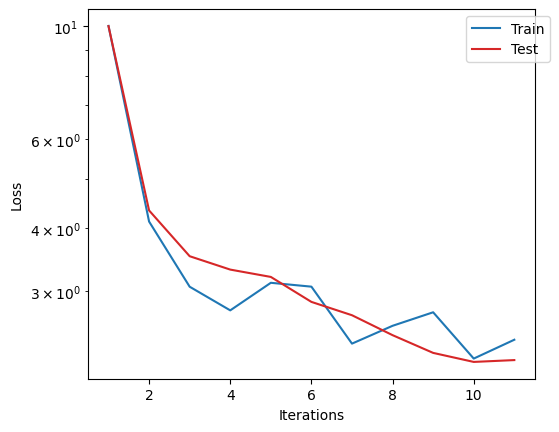

In [ ]:
# training
epochs = 30000
model_mlp.train(data_train1, data_test, nIter = epochs)
model_mlp.plot_losses('')

In [188]:
# loading the trained model 
fno_layers = [Dense(32), 
          Permute("ijkl->iljk"), 
          FNOBlock2D(32, 16), Gelu,
          FNOBlock2D(32, 16), Gelu,
          FNOBlock2D(32, 16),
          Permute("ijkl->iklj"),
          Dense(128), 
          Gelu,
          Dense(3)]
model_fno = SPiFOL(
    arch='FNO',
    N=64, # latent size
    layers=None,
    fno_layers=fno_layers,
    lr=0.001,
    activation=jax.nn.relu, # here its not used
    norm_par=1000.0
) 
# trianed model params are above
flat_params  = np.load("./data/FNO_32_16_multiple.npy")
params1 = model_fno.unravel(flat_params)
model_fno.params = params1

TypeError: FNOBlock2D() takes 1 positional argument but 2 were given

In [186]:
# prediction 
data = data_test[2]
data = model_fno.full_sample(data)
E1 = (data).reshape(n,n)
eps = model_fno.operator_net(params1, E1)
sigma  = model_fno.material_model(C_f, C_m, eps, E1)

NameError: name 'params1' is not defined